
# Tema: Regresie polinomială, Regresie logistică și Naive Bayes

Acest notebook conține rezolvările (cod + grafice + metrici) pentru toate cele trei probleme cerute de tine: **regresie polinomială** (fermier & fertilizator), **regresie logistică** (boală cardiacă) și **clasificator Naive Bayes** (spam).

Fiecare secțiune are: împărțirea datelor, antrenare model, metrici (train/test), vizualizări și concluzii. Pune notebook-ul în Google Colab: `File > Upload notebook` sau deschide-l din Drive după ce-l încarci.

---


In [1]:

# Librării folosite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')


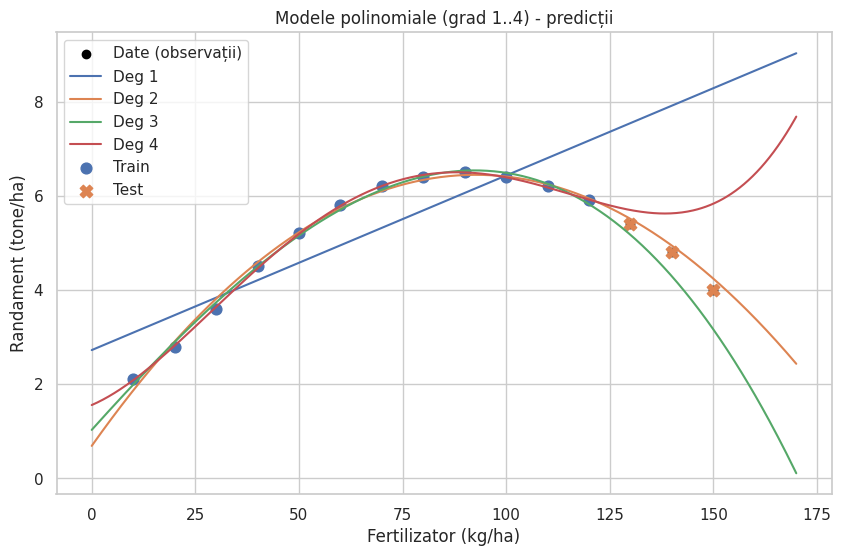

Metrici pentru modelele polinomiale (1..4):
{ 1: { 'MAE_test': 3.17972027972028,
       'MAE_train': 0.6333333333333333,
       'MSE_test': 10.877008112322793,
       'MSE_train': 0.511942501942502,
       'R2_test': -32.07198412530577,
       'R2_train': 0.7617640890650198,
       'RMSE_test': np.float64(3.298030944718802),
       'RMSE_train': np.float64(0.7155015736827572),
       'opt_amount': 170.0,
       'opt_value': 9.024941724941725},
  2: { 'MAE_test': 0.16323676323676098,
       'MAE_train': 0.08771228771228771,
       'MSE_test': 0.02971612470113902,
       'MSE_train': 0.012174492174492174,
       'R2_test': 0.9096469181384287,
       'R2_train': 0.9943345176023562,
       'RMSE_test': np.float64(0.1723836555510383),
       'RMSE_train': np.float64(0.11033808125254026),
       'opt_amount': 92.66533066132264,
       'opt_value': 6.44445069751474},
  3: { 'MAE_test': 0.5267399267398601,
       'MAE_train': 0.0687590187590249,
       'MSE_test': 0.33922181714382144,
       '

In [2]:

# ---------------------------
# 1) Regresie polinomială
# ---------------------------
X = np.array([10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]).reshape(-1,1)
y = np.array([2.1,2.8,3.6,4.5,5.2,5.8,6.2,6.4,6.5,6.4,6.2,5.9,5.4,4.8,4.0])

# Împărțire: primele 12 puncte = antrenare, ultimele 3 = testare
X_train, X_test = X[:12], X[12:15]
y_train, y_test = y[:12], y[12:15]

results = {}

plt.figure(figsize=(10,6))
plt.scatter(X, y, label='Date (observații)', color='black')

# evaluare pentru gradele 1..4
xs_dense = np.linspace(0,170,500).reshape(-1,1)
for deg in [1,2,3,4]:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    Xtr_poly = poly.fit_transform(X_train)
    Xte_poly = poly.transform(X_test)
    Xdense_poly = poly.transform(xs_dense)
    lr = LinearRegression()
    lr.fit(Xtr_poly, y_train)
    # predicții
    ytr_pred = lr.predict(Xtr_poly)
    yte_pred = lr.predict(Xte_poly)
    ydense = lr.predict(Xdense_poly)
    # metrici
    metrics = {}
    metrics['MAE_train'] = mean_absolute_error(y_train, ytr_pred)
    metrics['MSE_train'] = mean_squared_error(y_train, ytr_pred)
    metrics['RMSE_train'] = np.sqrt(metrics['MSE_train'])
    metrics['R2_train'] = r2_score(y_train, ytr_pred)
    metrics['MAE_test'] = mean_absolute_error(y_test, yte_pred)
    metrics['MSE_test'] = mean_squared_error(y_test, yte_pred)
    metrics['RMSE_test'] = np.sqrt(metrics['MSE_test'])
    metrics['R2_test'] = r2_score(y_test, yte_pred)
    # cantitate optima (maxim predicted)
    opt_idx = np.argmax(ydense)
    opt_amount = xs_dense[opt_idx,0]
    opt_value = ydense[opt_idx]
    metrics['opt_amount'] = float(opt_amount)
    metrics['opt_value'] = float(opt_value)
    results[deg] = metrics
    # plot
    plt.plot(xs_dense, ydense, label=f'Deg {deg}')

# plot train/test markers with different markers
plt.scatter(X_train, y_train, label='Train', marker='o', s=60)
plt.scatter(X_test, y_test, label='Test', marker='X', s=80)
plt.xlabel('Fertilizator (kg/ha)')
plt.ylabel('Randament (tone/ha)')
plt.legend()
plt.title('Modele polinomiale (grad 1..4) - predicții')
plt.show()

# afișare metrici
import pprint
pp = pprint.PrettyPrinter(indent=2)
print('Metrici pentru modelele polinomiale (1..4):')
pp.pprint(results)


--- Metrics for train ---
Accuracy: 0.9285714285714286
Precision: 0.875
Recall: 1.0
F1: 0.9333333333333333
ROC AUC: 0.979591836734694
Confusion matrix:
 [[6 1]
 [0 7]]

--- Metrics for test ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: nan
Confusion matrix:
 [[4]]



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


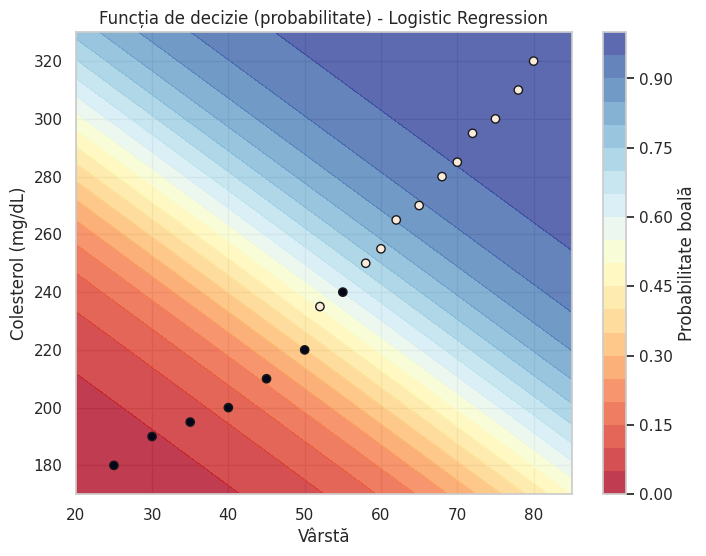

Probabilitatea prezisă de boală pentru (55 ani, colesterol 260) = 0.7513

Coeficienți (logit):
  age: 0.9317 (impact asupra log-odds, semn -> direcție)
  cholesterol: 1.1794 (impact asupra log-odds, semn -> direcție)


In [3]:

# ---------------------------
# 2) Regresie logistică
# ---------------------------
age = np.array([25,30,35,40,45,50,52,55,58,60,62,65,68,70,72,75,78,80])
chol = np.array([180,190,195,200,210,220,235,240,250,255,265,270,280,285,295,300,310,320])
y_card = np.array([0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1])

X = np.vstack([age, chol]).T
# split: first 14 train, last 4 test
X_train, X_test = X[:14], X[14:18]
y_train, y_test = y_card[:14], y_card[14:18]

# scale features
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xtr_s, y_train)

# predicții și probabilități
ytr_pred = clf.predict(Xtr_s)
yte_pred = clf.predict(Xte_s)
ytr_prob = clf.predict_proba(Xtr_s)[:,1]
yte_prob = clf.predict_proba(Xte_s)[:,1]

# metrici
def print_log_metrics(y_true, y_pred, y_prob, name='set'):
    print(f'--- Metrics for {name} ---')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, zero_division=0))
    print('Recall:', recall_score(y_true, y_pred, zero_division=0))
    print('F1:', f1_score(y_true, y_pred, zero_division=0))
    try:
        print('ROC AUC:', roc_auc_score(y_true, y_prob))
    except Exception as e:
        print('ROC AUC: N/A', e)
    print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
    print()

print_log_metrics(y_train, ytr_pred, ytr_prob, 'train')
print_log_metrics(y_test, yte_pred, yte_prob, 'test')

# Vizualizare funcție decizie (probabilitate) pe grid - 2D
xx, yy = np.meshgrid(np.linspace(age.min()-5, age.max()+5, 200),
                     np.linspace(chol.min()-10, chol.max()+10, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_s = scaler.transform(grid)
probs = clf.predict_proba(grid_s)[:,1].reshape(xx.shape)

plt.figure(figsize=(8,6))
cs = plt.contourf(xx, yy, probs, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(cs, label='Probabilitate boală')
plt.scatter(X[:,0], X[:,1], c=y_card, edgecolor='k')
plt.xlabel('Vârstă')
plt.ylabel('Colesterol (mg/dL)')
plt.title('Funcția de decizie (probabilitate) - Logistic Regression')
plt.show()

# predictie pentru persoana de 55 ani si colesterol 260 mg/dL
sample = np.array([[55, 260]])
sample_s = scaler.transform(sample)
prob_sample = clf.predict_proba(sample_s)[:,1][0]
print(f'Probabilitatea prezisă de boală pentru (55 ani, colesterol 260) = {prob_sample:.4f}')

# importanța caracteristicilor: coeficienți
coef = clf.coef_[0]
feat_names = ['age','cholesterol']
print('\nCoeficienți (logit):')
for n,c in zip(feat_names, coef):
    print(f'  {n}: {c:.4f} (impact asupra log-odds, semn -> direcție)')


In [6]:

# ---------------------------
# 3) Naive Bayes (Spam)
# ---------------------------
# Construim DataFrame manual
data = {
    'Free': ['Da','Da','Nu','Da','Nu','Da','Nu','Nu','Da','Nu','Da','Nu','Da','Nu','Nu','Da','Nu','Da','Nu','Nu'],
    'Money': ['Da','Da','Nu','Nu','Nu','Da','Da','Nu','Da','Nu','Nu','Nu','Da','Da','Nu','Da','Nu','Nu','Nu','Nu'],
    'Winner': ['Da','Nu','Nu','Da','Nu','Da','Nu','Nu','Da','Da','Nu','Nu','Da','Da','Nu','Nu','Nu','Da','Da','Nu'],
    'Link': ['Da','Da','Nu','Da','Da','Da','Da','Nu','Nu','Nu','Da','Nu','Da','Da','Da','Da','Nu','Da','Nu','Nu'],
    'Spam': [1,1,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0,1,1,0]
}
df = pd.DataFrame(data)
# codificare Da/Nu -> 1/0
df_bin = df.replace({'Da':1,'Nu':0})
X = df_bin[['Free','Money','Winner','Link']].values
y = df_bin['Spam'].values

# split: primele 16 train, ultimele 4 test
X_train, X_test = X[:16], X[16:20]
y_train, y_test = y[:16], y[16:20]

# 2) Calculare manual priors (train)
p_spam = y_train.mean()
p_notspam = 1 - p_spam
print('P(Spam) =', p_spam, ' P(NotSpam)=', p_notspam)

# 3) probabilitati conditionale P(feature|class) (fara Laplace)
def cond_probs(X, y):
    # returns P(feature=1|class=1) and P(feature=1|class=0)
    probs = {}
    for i,feat in enumerate(['Free','Money','Winner','Link']):
        p1 = X[y==1,i].mean() if np.sum(y==1)>0 else 0
        p0 = X[y==0,i].mean() if np.sum(y==0)>0 else 0
        probs[feat] = {'P(feature=1|Spam)=%.3f'%p1: p1, 'P(feature=1|NotSpam)=%.3f'%p0: p0}
    return probs

probs_no_laplace = cond_probs(X_train, y_train)
print('\nProb. condiționale (fără Laplace):')
for k,v in probs_no_laplace.items():
    print(k, v)

# 4) Clasificare manuală pentru nou email: Free=Da,Money=Nu,Winner=Da,Link=Da
new = np.array([1,0,1,1])
# Calcul manual: P(Spam|x) ∝ P(Spam) * Π P(feature_i|Spam) (if feature=1 use p, if 0 use 1-p)
def manual_nb_predict(x, p_spam, p_notspam, X_train, y_train, laplace=False, alpha=1):
    # compute conditional probabilities with optional Laplace smoothing
    cond = {}
    n_spam = np.sum(y_train==1)
    n_not = np.sum(y_train==0)
    for i,feat in enumerate(['Free','Money','Winner','Link']):
        # counts
        count_spam = np.sum(X_train[y_train==1,i]==1)
        count_not = np.sum(X_train[y_train==0,i]==1)
        if laplace:
            p_f_given_spam = (count_spam + alpha) / (n_spam + 2*alpha)
            p_f_given_not = (count_not + alpha) / (n_not + 2*alpha)
        else:
            p_f_given_spam = count_spam / n_spam if n_spam>0 else 0
            p_f_given_not = count_not / n_not if n_not>0 else 0
        cond[feat] = (p_f_given_spam, p_f_given_not)
    # compute likelihoods
    lik_spam = p_spam
    lik_not = p_notspam
    for i,val in enumerate(x):
        p1_spam, p1_not = cond[['Free','Money','Winner','Link'][i]]
        if val==1:
            lik_spam *= p1_spam
            lik_not *= p1_not
        else:
            lik_spam *= (1-p1_spam)
            lik_not *= (1-p1_not)
    # normalize
    total = lik_spam + lik_not
    prob_spam = lik_spam / total if total>0 else 0
    return prob_spam, cond

prob_manual, conds = manual_nb_predict(new, p_spam, p_notspam, X_train, y_train, laplace=False)
print('\nProbabilitate manuală (fără Laplace) pentru noul email =', prob_manual)
print('\nCondiționale folosite:')
for k,v in conds.items():
    print(k, 'P(1|Spam)=%.3f, P(1|Not)=%.3f' % v)

# 5) Antrenare model BernoulliNB și comparare
clf = BernoulliNB(alpha=1.0)  # Laplace smoothing by default alpha=1
clf.fit(X_train, y_train)
print('\nBernoulliNB (with Laplace alpha=1) - trained')
print('Pred nou (prob spam) =', clf.predict_proba([new])[0,1])

# 6) Matrice confuzie și metrici train/test
for name,(Xt,yt) in [('train',(X_train,y_train)),('test',(X_test,y_test))]:
    pred = clf.predict(Xt)
    print(f'\n--- Metrics {name} ---')
    print('Confusion matrix:\n', confusion_matrix(yt, pred))
    print('Accuracy:', accuracy_score(yt,pred))
    print('Precision:', precision_score(yt,pred, zero_division=0))
    print('Recall:', recall_score(yt,pred, zero_division=0))
    print('F1:', f1_score(yt,pred, zero_division=0))

# 7) Efectul Laplace: comparam probabilitățile manual cu/ fără Laplace
prob_manual_lap, conds_lap = manual_nb_predict(new, p_spam, p_notspam, X_train, y_train, laplace=True, alpha=1)
print('\nProb manual (cu Laplace alpha=1) =', prob_manual_lap)

# 8) Importanța caracteristici: log prob ratio (BernoulliNB) - features cu cel mai mare uplift pentru spam
# folosim log(P(feature=1|Spam)/P(feature=1|NotSpam))
feature_importance = {}
for i,feat in enumerate(['Free','Money','Winner','Link']):
    p1_spam = clf.feature_log_prob_[1,i]  # log P(x_i=1 | class=1)
    p1_not = clf.feature_log_prob_[0,i]   # log P(x_i=1 | class=0)
    # compute difference of log-probs
    feature_importance[feat] = float(p1_spam - p1_not)
print('\nFeature importance (log-prob difference) - higher means more indicative for Spam:')
for k,v in sorted(feature_importance.items(), key=lambda x:-x[1]):
    print(k, v)


P(Spam) = 0.625  P(NotSpam)= 0.375

Prob. condiționale (fără Laplace):
Free {'P(feature=1|Spam)=0.800': np.float64(0.8), 'P(feature=1|NotSpam)=0.000': np.float64(0.0)}
Money {'P(feature=1|Spam)=0.800': np.float64(0.8), 'P(feature=1|NotSpam)=0.000': np.float64(0.0)}
Winner {'P(feature=1|Spam)=0.600': np.float64(0.6), 'P(feature=1|NotSpam)=0.167': np.float64(0.16666666666666666)}
Link {'P(feature=1|Spam)=0.900': np.float64(0.9), 'P(feature=1|NotSpam)=0.333': np.float64(0.3333333333333333)}

Probabilitate manuală (fără Laplace) pentru noul email = 1.0

Condiționale folosite:
Free P(1|Spam)=0.800, P(1|Not)=0.000
Money P(1|Spam)=0.800, P(1|Not)=0.000
Winner P(1|Spam)=0.600, P(1|Not)=0.167
Link P(1|Spam)=0.900, P(1|Not)=0.333

BernoulliNB (with Laplace alpha=1) - trained
Pred nou (prob spam) = 0.9367681498829039

--- Metrics train ---
Confusion matrix:
 [[ 6  0]
 [ 0 10]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

--- Metrics test ---
Confusion matrix:
 [[2 0]
 [1 1]]
Accuracy: 0.75
P

/tmp/ipython-input-467681425.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bin = df.replace({'Da':1,'Nu':0})
